In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
folder_path = "SOCOFing"
file_list_real = os.listdir(folder_path + '/Real')
file_list_alt_easy = os.listdir(folder_path + '/Altered/Altered-Easy')
file_list_alt_medium = os.listdir(folder_path + '/Altered/Altered-Medium')

result_real = [[element for element in file_list_real if element.startswith(str(idx) + '_') and "Right_index" in element] for idx in range(601)]
result_alt_easy = [[element for element in file_list_alt_easy if element.startswith(str(idx) + '_') and "Right_index" in element] for idx in range(601)]
result_alt_medium = [[element for element in file_list_alt_medium if element.startswith(str(idx) + '_') and "Right_index" in element] for idx in range(601)]

complete_idxs = [idx for idx in range(601) if len(result_alt_easy[idx]) == 3 and len(result_alt_medium[idx]) == 3 and idx != 53 and idx !=226]

inp_real_200 = [result_real[idx] for idx in complete_idxs][:200]
inp_alt_easy_200 = [result_alt_easy[idx] for idx in complete_idxs][:200]
inp_alt_medium_200 = [result_alt_medium[idx] for idx in complete_idxs][:200]

transform = transforms.ToTensor()

tensors_alt_easy_200 = [[transform(Image.open(os.path.join(folder_path, 'Altered/Altered-Easy', image_path)).convert("L")) for image_path in paths_list] for paths_list in inp_alt_easy_200]
tensors_alt_medium_200 = [[transform(Image.open(os.path.join(folder_path, 'Altered/Altered-Medium', image_path)).convert("L")) for image_path in paths_list] for paths_list in inp_alt_medium_200]
imgs_list_200 = [tensors_alt_easy_200[i] + tensors_alt_medium_200[i] for i in range(200)]



In [3]:
train_imgs = [imgs[:5] for imgs in imgs_list_200[:100]]
test_imgs = [imgs[5] for imgs in imgs_list_200]

In [4]:
class FingerprintDataset(Dataset):
    def __init__(self):
        pass
    
    def __len__(self):
        return 100
    
    def __getitem__(self, index):

        idx_anchor = random.choice(list(range(5)))
        idx_positive = random.choice([num for num in list(range(5)) if num != idx_anchor])
        idx_negative_i = random.choice([num for num in list(range(100)) if num != index])
        idx_negative_j = random.choice(list(range(5)))
        
        return train_imgs[index][idx_anchor], train_imgs[index][idx_positive], train_imgs[idx_negative_i][idx_negative_j]



In [5]:
dataset = FingerprintDataset()

In [6]:
import torch
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)

        self.fc1 = nn.Linear(2880, 128*2)
        self.fc2 = nn.Linear(128*2, 128*3)
        self.fc3 = nn.Linear(128*3, 128)

        self.ln = nn.LayerNorm(128)

        self.fc4 = nn.Linear(128, 2)

    def forward(self, x1, x2):
        output1 = self.process_images(x1)
        output2 = self.process_images(x2)

        diff = torch.abs(output1 - output2)

        output = self.fc4(diff)

        probabilities = torch.softmax(output, dim=1)

        return probabilities[:, 1]

    def process_images(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=3)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=3)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.ln(x)
        return x


In [7]:
siamese_net = SiameseNetwork()

In [8]:
data_loader = DataLoader(dataset, batch_size=100, shuffle=False)

In [631]:
# Assuming you have your train_loader, test_loader, siamese_net, loss_function, and optimizer defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_net.to(device)

num_epochs = 3000

loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(siamese_net.parameters(), lr=0.01)

for epoch in range(num_epochs):
    siamese_net.train()
    train_loss = 0.0
    
    for batch_idx, (anchor, sample_pos, sample_neg) in enumerate(data_loader):
        
        optimizer.zero_grad()

        prob = siamese_net(torch.cat((anchor, anchor)), torch.cat((sample_pos, sample_neg)))

        loss = loss_function(prob, torch.tensor([1.0 for i in range(100)] + [0.0 for i in range(100)]))
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss}")


Epoch 0/3000, Train Loss: 0.4584532082080841
Epoch 1/3000, Train Loss: 0.5379549264907837
Epoch 2/3000, Train Loss: 0.47149837017059326
Epoch 3/3000, Train Loss: 0.486504465341568
Epoch 4/3000, Train Loss: 0.47226282954216003
Epoch 5/3000, Train Loss: 0.41088148951530457
Epoch 6/3000, Train Loss: 0.416897177696228
Epoch 7/3000, Train Loss: 0.3930438756942749
Epoch 8/3000, Train Loss: 0.3885287046432495
Epoch 9/3000, Train Loss: 0.3888525366783142
Epoch 10/3000, Train Loss: 0.36354178190231323
Epoch 11/3000, Train Loss: 0.3589460849761963
Epoch 12/3000, Train Loss: 0.33647945523262024
Epoch 13/3000, Train Loss: 0.33727458119392395
Epoch 14/3000, Train Loss: 0.32326412200927734
Epoch 15/3000, Train Loss: 0.31878939270973206
Epoch 16/3000, Train Loss: 0.3070276379585266
Epoch 17/3000, Train Loss: 0.32115882635116577
Epoch 18/3000, Train Loss: 0.2940431833267212
Epoch 19/3000, Train Loss: 0.29097479581832886
Epoch 20/3000, Train Loss: 0.2956151068210602
Epoch 21/3000, Train Loss: 0.2937006

In [9]:
def predict(idx, threshold):
    new_img = test_imgs[idx].unsqueeze(0)
    res_list = [siamese_net(new_img, train_imgs[i][0].unsqueeze(0)).item() for i in range(100)]
    if max(res_list) > threshold:
        return res_list.index(max(res_list))
    else:
        return -1

def predictions(threshold):
    predictions = []
    for i in range(200):
        pred = predict(i, threshold)
        predictions.append(pred)
    return predictions

def max_probabilities():
    max_probabilities = []
    for idx in range(200):
        new_img = test_imgs[idx].unsqueeze(0)
        res_list = [siamese_net(new_img, train_imgs[i][0].unsqueeze(0)).item() for i in range(100)]
        max_probabilities.append(max(res_list))
    return max_probabilities
    

In [10]:
import pickle

# with open('trained_model.pickle', 'wb') as file:
#     pickle.dump(siamese_net, file)

In [11]:
with open('trained_model.pickle', 'rb') as file:
    siamese_net = pickle.load(file)

In [14]:
preds = predictions(0.98)

In [15]:
correct_labels = [i for i in range(100)] + [-1 for i in range(100)]

accuracy = accuracy_score(correct_labels, preds)
f1 = f1_score(correct_labels, preds, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.95
F1 Score: 0.9466895669158755


In [19]:
preds_90 = predictions(0.90)
preds_95 = predictions(0.95)
preds_99 = predictions(0.99)

In [20]:
print("Accuracy threshold 90: ", accuracy_score(correct_labels, preds_90))
print("Accuracy threshold 95: ", accuracy_score(correct_labels, preds_95))
print("Accuracy threshold 99: ", accuracy_score(correct_labels, preds_99))

Accuracy threshold 90:  0.91
Accuracy threshold 95:  0.925
Accuracy threshold 99:  0.945


In [14]:
max_probabilities = max_probabilities()

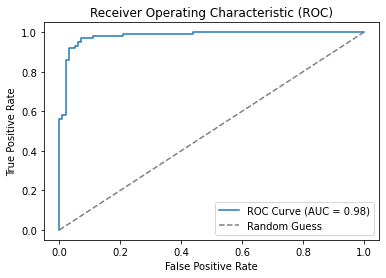

In [15]:
true_labels = [1 for i in range(100)] + [0 for i in range(100)]

fpr, tpr, thresholds = roc_curve(true_labels, max_probabilities)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

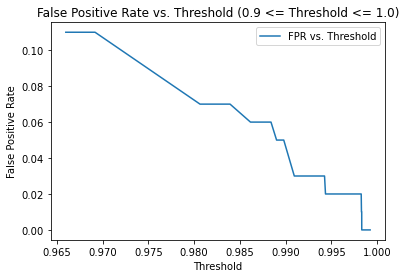

In [16]:
valid_indices = (thresholds >= 0.9) & (thresholds <= 1.0)
filtered_fpr = fpr[valid_indices]
filtered_thresholds = thresholds[valid_indices]

# Plot the filtered FPR vs. Threshold curve
plt.plot(filtered_thresholds, filtered_fpr, label='FPR vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold (0.9 <= Threshold <= 1.0)')
plt.legend()
plt.show()

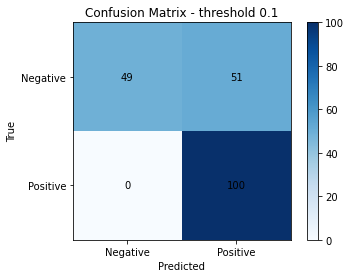

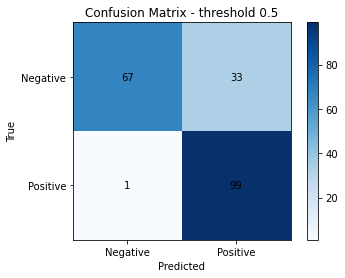

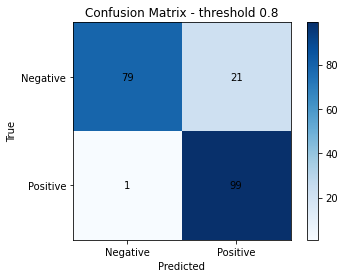

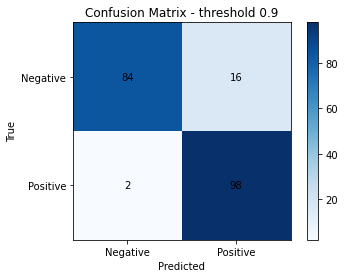

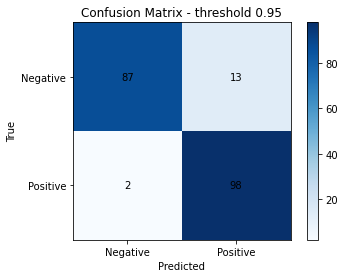

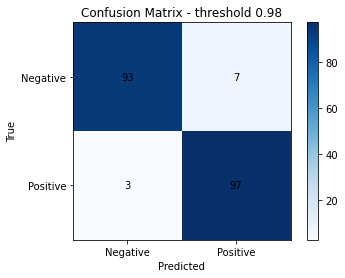

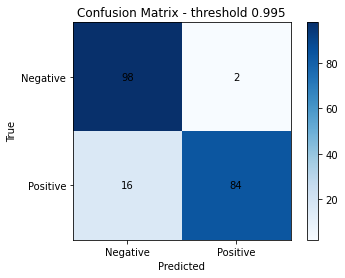

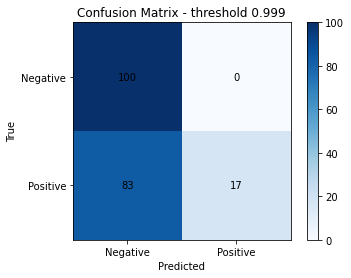

In [19]:
def plot_conf_matrix(threshold):
    predicted_labels = [int(i >= threshold) for i in max_probabilities]
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - threshold ' + str(threshold))
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
    plt.show()

for i in [0.1, 0.5, 0.8, 0.9, 0.95, 0.98, 0.995, 0.999]:
    plot_conf_matrix(i)

In [14]:
accuracies = []
thresholds_list = [0.1 * i for i in range(1, 10)]
for t in thresholds_list:
    t_preds = predictions(t)
    accuracies.append(accuracy_score(correct_labels, t_preds))

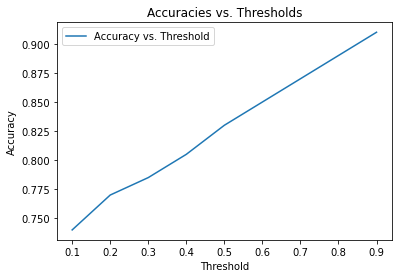

In [15]:
plt.plot(thresholds_list, accuracies, label='Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracies vs. Thresholds')
plt.legend()
plt.show()

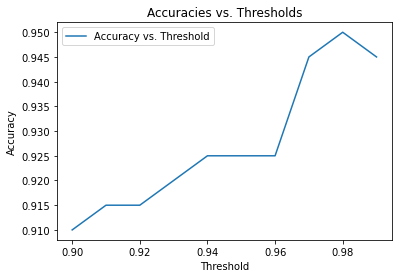

In [16]:
accuracies = []
thresholds_list = [0.01 * i + 0.9 for i in range(10)]
for t in thresholds_list:
    t_preds = predictions(t)
    accuracies.append(accuracy_score(correct_labels, t_preds))

plt.plot(thresholds_list, accuracies, label='Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracies vs. Thresholds')
plt.legend()
plt.show()

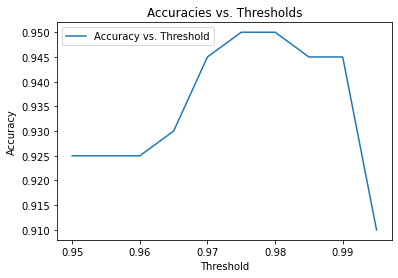

In [16]:
accuracies = []
t_preds_list = []
thresholds_list = [0.005 * i + 0.95 for i in range(10)]
for t in thresholds_list:
    t_preds = predictions(t)
    accuracies.append(accuracy_score(correct_labels, t_preds))
    t_preds_list.append(t_preds)

plt.plot(thresholds_list, accuracies, label='Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracies vs. Thresholds')
plt.legend()
plt.show()

In [17]:
fars = [sum([int(t_pred >= 0 and label != t_pred) for label, t_pred in list(zip(correct_labels, t_preds))])/100. for t_preds in t_preds_list]
frrs = [sum([int(t_pred == -1 and label > 0) for label, t_pred in list(zip(correct_labels, t_preds))])/100. for t_preds in t_preds_list]

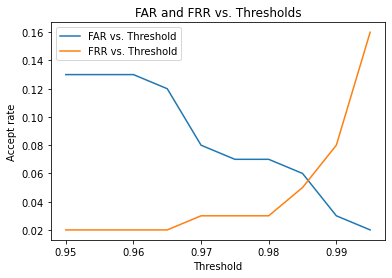

In [18]:
plt.plot(thresholds_list, fars, label='FAR vs. Threshold')
plt.plot(thresholds_list, frrs, label='FRR vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accept rate')
plt.title('FAR and FRR vs. Thresholds')
plt.legend()
plt.show()